Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
from itertools import compress
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [7]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
for index in data[:10]:
    print (reverse_dictionary[index])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
anarchism
originated
as
a
term
of
abuse
first
used
against


In [5]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print (take(10, dictionary.iteritems()))

[('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554), ('sowell', 40562), ('sonja', 38175), ('showa', 32906), ('woods', 6263), ('hsv', 44222)]


Function to generate a training batch for the skip-gram model.

In [9]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'anarchism', 'term', 'of', 'term', 'originated', 'as']


In [277]:
for num_skips, skip_window in [(2, 1), (4, 2)]:
    print ("num_skips: ", num_skips, " , skip_window: ", skip_window)

num_skips:  2  , skip_window:  1
num_skips:  4  , skip_window:  2


Train a skip-gram model.

In [278]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  print ("valid_examples: ",valid_examples)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  print ('normalized_embedding: ', normalized_embeddings)
  print ('valid_embedding: ', valid_embeddings)
  print ("embed: ", embed)
  print ('embeddings: ', embeddings.get_shape)
  print ('similarity: ',similarity)    

valid_examples:  [38 48 46  7 76 27 80 81 55 98 35 82  0 92 90 88]
normalized_embedding:  Tensor("div:0", shape=(50000, 128), dtype=float32, device=/device:CPU:0)
valid_embedding:  Tensor("embedding_lookup_1:0", shape=(16, 128), dtype=float32, device=/device:CPU:0)
embed:  Tensor("embedding_lookup:0", shape=(128, 128), dtype=float32, device=/device:CPU:0)
embeddings:  <bound method Variable.get_shape of <tensorflow.python.ops.variables.Variable object at 0x7f1cea0fa410>>
similarity:  Tensor("MatMul:0", shape=(16, 50000), dtype=float32, device=/device:CPU:0)


In [279]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.513244
Nearest to not: transplants, fugues, elas, cautionary, mouths, trumpeter, devas, summarised,
Nearest to some: jenner, calculates, convocation, grupo, invariant, warned, mcgregor, ld,
Nearest to first: pacemaker, bulge, vote, gdp, leak, learners, franchise, genghis,
Nearest to to: undisclosed, hgh, economic, geospatial, artur, mutinies, interfaces, harnessing,
Nearest to no: qquad, promise, appleseed, resolution, goidelic, slabs, mein, stg,
Nearest to it: ineligible, gang, enlargement, vigilance, hammerhead, secular, fingerprinting, adversarial,
Nearest to over: boasian, coached, harpers, humans, frank, marques, nubia, akh,
Nearest to years: punishment, rewarded, machines, auden, avenge, point, pasadena, finiteness,
Nearest to such: affectionately, arya, themselves, calls, america, allosteric, npc, impressionists,
Nearest to up: conqueror, plasticizers, wikiquote, servant, necklaces, maasai, maoists, sufferers,
Nearest to at: relieving, basic

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

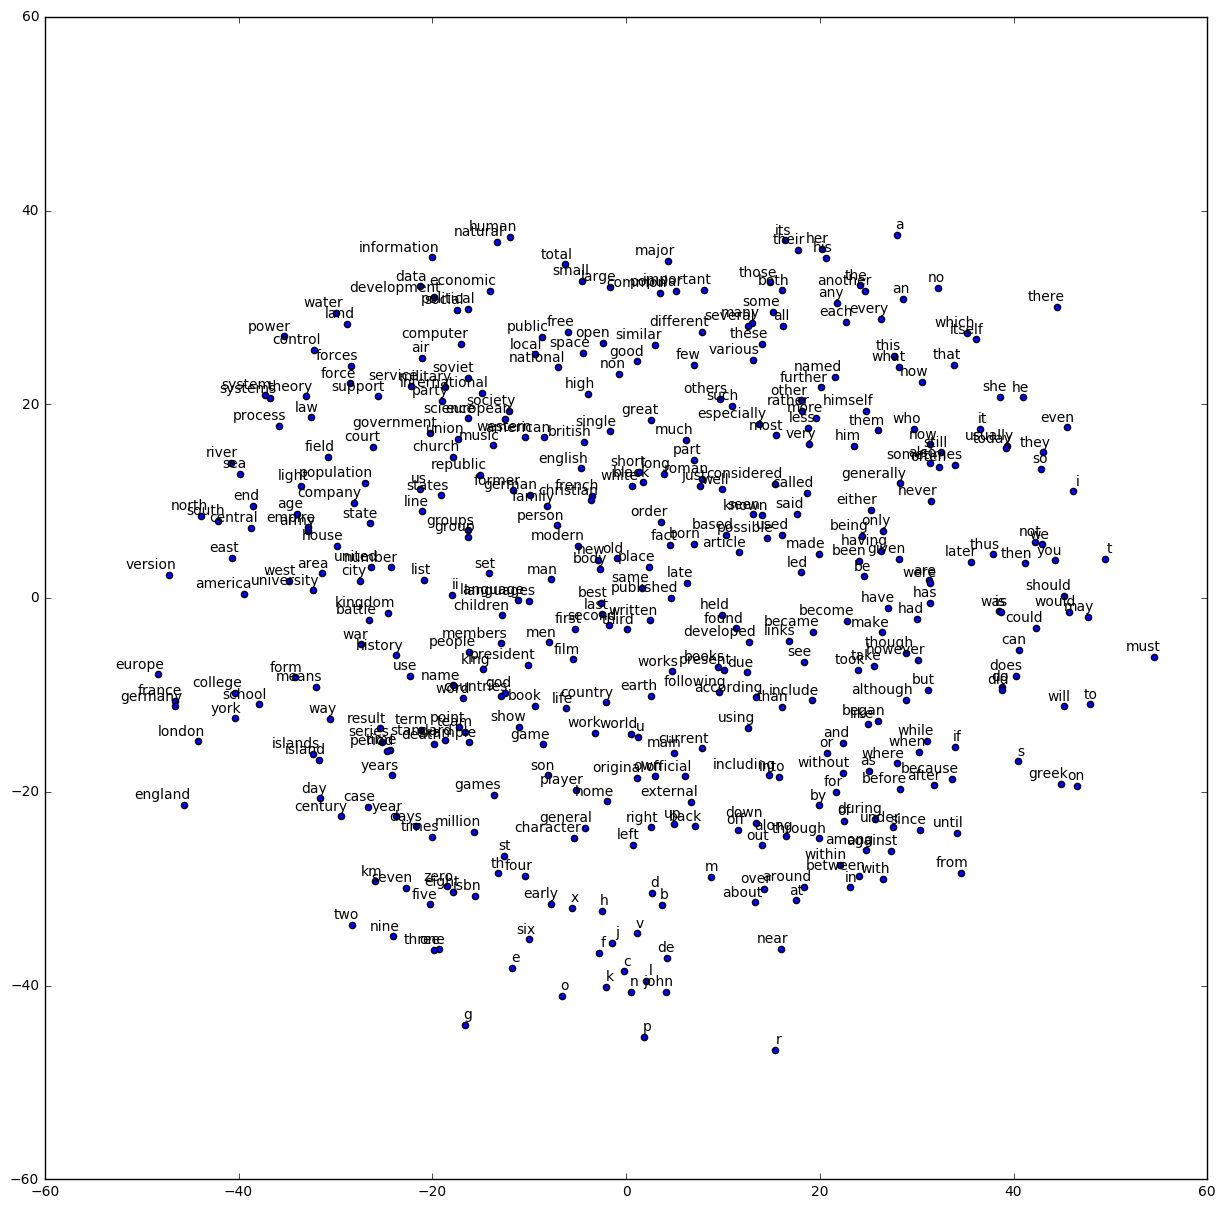

In [14]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [291]:
def generate_batch_cbow(data, batch_size, num_skips, skip_window):
	'''
	Batch generator for CBOW (Continuous Bag of Words).
	batch should be a shape of (batch_size, num_skips)
	Parameters
	----------
	data: list of index of words
	batch_size: number of words in each mini-batch
	num_skips: number of surrounding words on both direction (2: one word ahead and one word following)
	skip_window: number of words at both ends of a sentence to skip (1: skip the first and last word of a sentence)
	'''
	global data_index
	assert batch_size % num_skips == 0
	assert num_skips <= 2 * skip_window
	batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
	labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
	span = 2 * skip_window + 1 # [ skip_window target skip_window ]
	buffer = collections.deque(maxlen=span) # used for collecting data[data_index] in the sliding window
	# collect the first window of words
	for _ in range(span):
		buffer.append(data[data_index])
		#print (len(data)," and ",data_index)
		data_index = (data_index + 1) % len(data)
		#print(data_index)        
	# move the sliding window  
	for i in range(batch_size):
		mask = [1] * span
		mask[skip_window] = 0 
		batch[i, :] = list(compress(buffer, mask)) # all surrounding words
		#print (buffer)
		labels[i, 0] = buffer[skip_window] # the word at the center 
		buffer.append(data[data_index])
		data_index = (data_index + 1) % len(data)       
	return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_cbow(data, batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[int(bi)] for bi in np.nditer(batch)])
    print('    labels:', [reverse_dictionary[int(li)] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of', 'term', 'abuse', 'of', 'first', 'abuse', 'used', 'first', 'against']
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: ['anarchism', 'originated', 'a', 'term', 'originated', 'as', 'term', 'of', 'as', 'a', 'of', 'abuse', 'a', 'term', 'abuse', 'first', 'term', 'of', 'first', 'used', 'of', 'abuse', 'used', 'against', 'abuse', 'first', 'against', 'early', 'first', 'used', 'early', 'working']
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [292]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.zeros([batch_size, embedding_size])
  for j in range(num_skips):
    embed += tf.nn.embedding_lookup(embeddings, train_dataset[:, j])  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  #print ("valid_embeddings: ", valid_embeddings)
  #print ("similarity: ", similarity)
  #print("embed: ", embed.get_shape)

In [293]:
testphrase = ""
for i in range(200):
    testphrase = testphrase + " " + reverse_dictionary[data[i]]
print (testphrase)
valid_examples.size

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans UNK of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or UNK but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic institutions anar

16

In [295]:
num_steps = 250000

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_cbow(data,
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_normalized_embeddings = normalized_embeddings.eval()
  final_embeddings = embeddings.eval()

Initialized
Average loss at step 0: 7.375422
Nearest to for: explains, changes, aram, drang, clerihew, preferred, ius, ifor,
Nearest to as: larry, cape, draught, speleological, forgive, bpm, shiv, crusade,
Nearest to d: concepts, fezzan, lethargy, fe, torches, haig, ciudad, circumnavigate,
Nearest to known: reactant, clique, sculptors, fabrics, composing, dorset, alkenes, hakama,
Nearest to is: apology, malaya, unprofitable, infested, etruscan, kashima, dhabi, mcenroe,
Nearest to their: aphelion, timeless, emblazoned, medici, illumination, gradient, bleak, feasting,
Nearest to s: jabir, allotted, accustomed, machinima, elagabalus, hines, witwatersrand, mcghee,
Nearest to first: encumbered, britney, vassar, chain, unethical, arno, juror, moabites,
Nearest to would: dearth, lament, criswell, retention, silesia, ike, elm, beast,
Nearest to nine: tragic, insulation, kling, esoteric, usemodwiki, ridings, journals, repertoire,
Nearest to who: optimization, brushing, subset, jutta, evangelist

In [296]:
reverse_dictionary[dictionary['athens']]
dictionary['athens']
reverse_dictionary[final_embeddings]

TypeError: unhashable type: 'numpy.ndarray'

In [246]:
tf.nn.embedding_lookup(final_embeddings,[3])[0]
summed = final_embeddings[3,:]
neg_scaled_sim = -np.dot(final_embeddings, summed)

In [314]:
def get_question_answer(word1, word2, word3):
    idx1 = dictionary[word1]
    idx2 = dictionary[word2]
    idx3 = dictionary[word3]
    summed = final_normalized_embeddings[idx2,:] - final_normalized_embeddings[idx1,:] + final_normalized_embeddings[idx3,:]
    neg_scaled_sim = -np.dot(final_normalized_embeddings, summed)
    #print(reverse_dictionary[neg_scaled_sim[0]])
    ap = neg_scaled_sim.argpartition(3)
    # argpartition() does not sort the partition, so it must be sorted separately.
    ap = ap[neg_scaled_sim[ap].argsort()]
    for idx in ap[0:3]:
        if idx != idx1 and idx != idx2 and idx != idx3:
            return reverse_dictionary[idx]
    return reverse_dictionary[ap[3]]


In [324]:
get_question_answer('ottawa','canada','paris')

'norway'